In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt

## Ⅰ. Overfitting

* 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태
  * 훈련 데이터가 적거나
  * 모델이 복잡한 경우

In [2]:
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

x_train = x_train[:300]
t_train = t_train[:300]

def monitor(weight_decay_lambda):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay_lambda)
    optimizer = SGD(lr=0.01)

    max_epochs = 201
    train_size = x_train.shape[0]
    batch_size = 100

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grads = network.gradient(x_batch, t_batch)
        optimizer.update(network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    markers = {'train': 'o', 'test': 's'}
    x = np.arange(max_epochs)
    plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
    plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')
    plt.show()

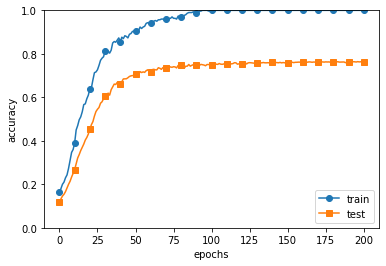

In [3]:
monitor(0)

## Ⅱ. Weight Decay

* 큰 가중치에 대해서 페널티를 부여하는 오버피팅을 방지
* 대표적으로 L2 norm값을 loss에 더해주는 방법이 있음

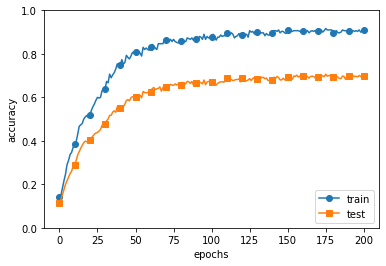

In [4]:
monitor(0.1)

## Ⅲ. Dropout

* 훈련시 뉴런을 무작위로 삭제하면서 학습하는 기법
* 성능이 더 좋아지는 이유 :
  * 노드간의 관계가 줄어들음
  * 앙상블의 효과가 있음
  * input에 노이즈를 더해주는 효과

<img src='../img/fig 6-22.png' width=50% height=50%/>

* 논문에서 사용하는 dropout

### 1. 구현

In [5]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

* 여러 프레임워크에서 사용하는 inverse dropout

In [6]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = (np.random.rand(*x.shape) > self.dropout_ratio) / (1.0 - self.dropout_ratio)
            return x * self.mask
        else:
            return x
    
    def backward(self, dout):
        return dout * self.mask

### 2. 비교

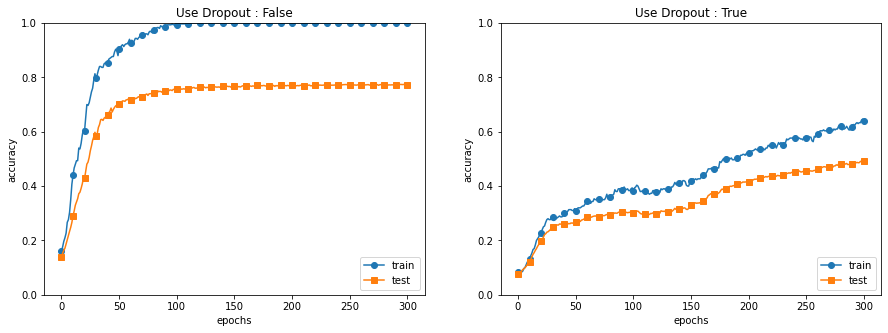

In [7]:
from common.trainer import Trainer
from common.multi_layer_net_extend import MultiLayerNetExtend

networks = []
train_acc_lists = []
test_acc_lists = []

use_dropout_flag = [False, True]
for use_dropout in use_dropout_flag:
    networks.append(MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                                        output_size=10, use_dropout=use_dropout, dropout_ration=0.2))

for network in networks: 
    trainer = Trainer(network, x_train, t_train, x_test, t_test, epochs=301, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=False)
    trainer.train()
    train_acc_lists.append(trainer.train_acc_list)
    test_acc_lists.append(trainer.test_acc_list) 

markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_lists[0]))
plt.figure(figsize=(15,5))

for i in range(len(networks)):
    plt.subplot(1, len(networks), i+1)
    plt.title(f'Use Dropout : {use_dropout_flag[i]}')
    plt.plot(x, train_acc_lists[i], marker='o', label='train', markevery=10)
    plt.plot(x, test_acc_lists[i], marker='s', label='test', markevery=10)
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.ylim(0, 1.0)
    plt.legend(loc='lower right')

plt.show()